# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
from ryp import r, to_py

In [3]:
r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [4]:
columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

In [5]:
def polys_to_df(polys):
    poly_labels = list(polys)
    poly_coords = list(polys.values())
    poly_coord_dim = np.shape(poly_coords[0])[-1]
    poly_df = pd.concat(
        [
            pd.DataFrame(
                poly_coords[i], columns=[f"V{i}" for i in range(poly_coord_dim)]
            ).assign(vertex=lambda df: df.index + 1, id=i, label=poly_labels[i])
            for i in range(len(polys))
        ],
        ignore_index=True,
    )
    return poly_df

In [6]:
poly_df = polys_to_df(polys)

In [7]:
columb["label"] = columb["district"]
poly_df = columb.merge(poly_df, on="label")

In [8]:
def plot_polys(df, color, polys, label):
    poly_df = polys_to_df(polys)
    df["label"] = df[label]
    plot_df = df.merge(poly_df, on="label")
    p = (
        p9.ggplot(plot_df)
        + p9.aes("V0", "V1", group="label", fill=color)
        + p9.geom_polygon()
    )
    return p

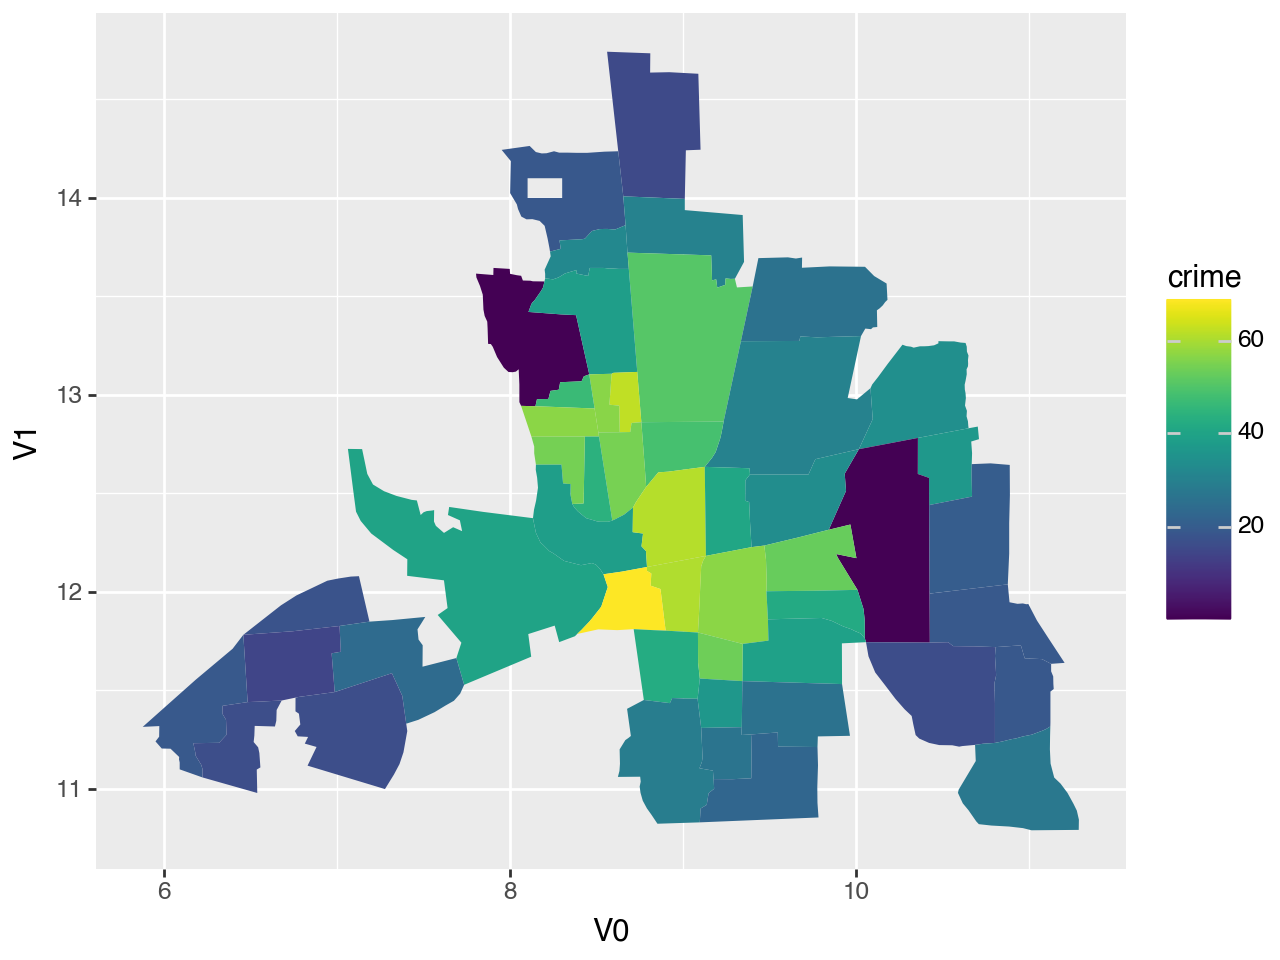

In [9]:
plot_polys(columb, "crime", polys, "district")

## Model Definition

### Setup response model

In [10]:
df = columb

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [11]:
tb = gam.TermBuilder.from_df(df)

In [12]:
loc += tb.mrf(
    "district",
    # scale=gam.ScaleIG(1.0, 0.01, 0.01),
    polys=polys,
    absorb_cons=True,
    diagonal_penalty=True,
    scale_penalty=True,
    noncentered=True,
    # inference=gs.MCMCSpec(gs.HMCKernel),
)

In [13]:
loc.terms["mrf1(district)"].labels

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


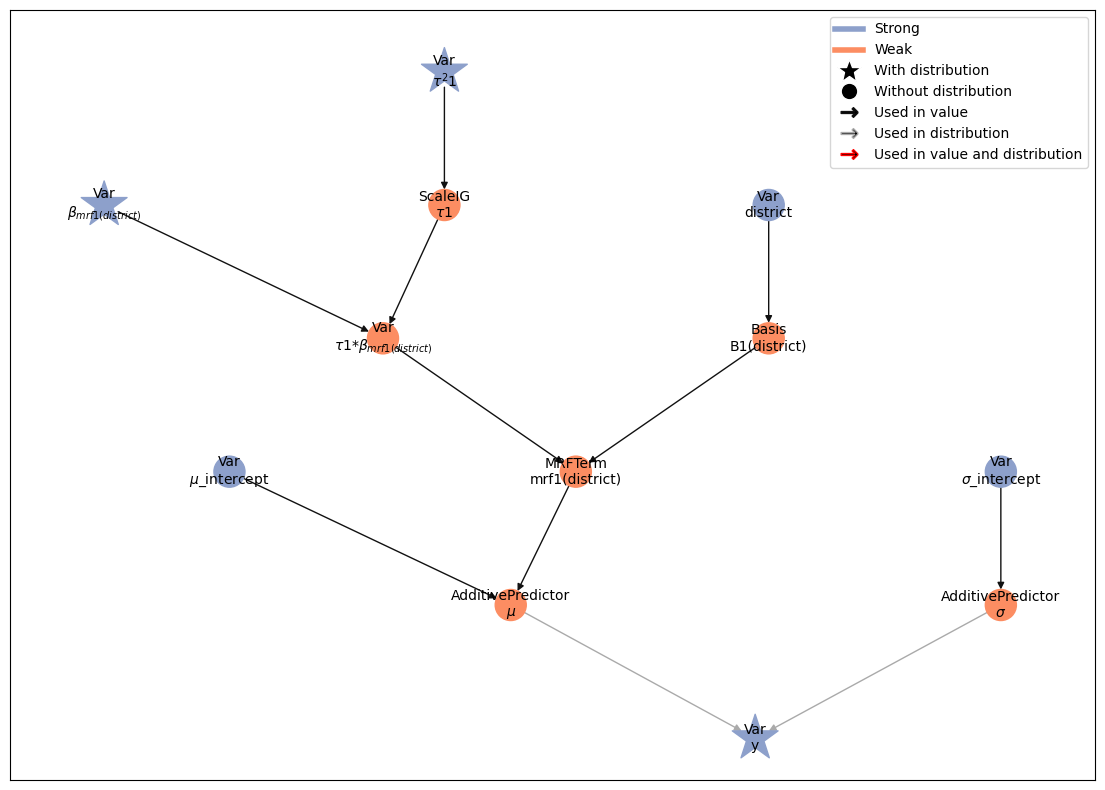

In [14]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [15]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{mrf1(district)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:03<00:00,  5.18chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1360.46chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1527.98chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO -

### MCMC summary

In [16]:
summary = gs.Summary(results)
summary

Parameter summary:

                                   kernel       mean        sd     q_0.05  \
parameter                index                                              
$\beta_{mrf1(district)}$ (0,)   kernel_02   0.157642  1.030108  -1.575486   
                         (1,)   kernel_02   0.005542  0.991507  -1.619361   
                         (2,)   kernel_02   0.133636  0.997394  -1.542077   
                         (3,)   kernel_02   0.184532  1.002545  -1.486846   
                         (4,)   kernel_02   0.062198  0.963802  -1.535161   
                         (5,)   kernel_02  -0.014540  0.965342  -1.596744   
                         (6,)   kernel_02  -0.074111  0.998800  -1.730475   
                         (7,)   kernel_02   0.024903  0.942495  -1.514259   
                         (8,)   kernel_02  -0.027592  0.970942  -1.615655   
                         (9,)   kernel_02   0.199067  1.034197  -1.513588   
                         (10,)  kernel_02   0.050188  0.979566  -1.553439   
                         (11,)  kernel_02  -0.047655  0.973283  -1.656222   
                         (12,)  kernel_02   0.015032  0.954368  -1.555885   
                         (13,)  kernel_02  -0.001290  0.946879  -1.537450   
                         (14,)  kernel_02  -0.002813  0.966069  -1.579662   
                         (15,)  kernel_02  -0.196567  1.041546  -1.920827   
                         (16,)  kernel_02   0.053727  0.978764  -1.572957   
                         (17,)  kernel_02   0.031123  0.969886  -1.573668   
                         (18,)  kernel_02   0.069376  0.985759  -1.535656   
                         (19,)  kernel_02  -0.142256  0.989318  -1.762671   
                         (20,)  kernel_02   0.129657  0.965075  -1.483115   
                         (21,)  kernel_02   0.357788  1.072156  -1.391291   
                         (22,)  kernel_02   0.029110  0.958757  -1.576274   
                         (23,)  kernel_02  -0.079066  0.971468  -1.635599   
                         (24,)  kernel_02  -0.132466  1.007558  -1.754056   
                         (25,)  kernel_02   0.051742  0.959734  -1.504416   
                         (26,)  kernel_02  -0.089880  0.993096  -1.673644   
                         (27,)  kernel_02  -0.060977  0.965330  -1.632988   
                         (28,)  kernel_02  -0.139271  0.975678  -1.702234   
                         (29,)  kernel_02  -0.115409  0.979578  -1.696947   
                         (30,)  kernel_02   0.109039  0.971202  -1.528351   
                         (31,)  kernel_02  -0.089219  0.969858  -1.677064   
                         (32,)  kernel_02  -0.204519  1.001820  -1.802176   
                         (33,)  kernel_02   0.096064  0.977930  -1.536394   
                         (34,)  kernel_02  -0.125031  0.959146  -1.670668   
                         (35,)  kernel_02   0.164337  0.948244  -1.420122   
                         (36,)  kernel_02   0.182679  0.967074  -1.461225   
                         (37,)  kernel_02  -0.100038  0.964023  -1.664411   
                         (38,)  kernel_02  -0.063165  0.943451  -1.619587   
                         (39,)  kernel_02   0.215618  0.985973  -1.440748   
                         (40,)  kernel_02  -0.332728  1.006416  -1.914114   
                         (41,)  kernel_02   0.277272  0.982897  -1.408931   
                         (42,)  kernel_02  -0.401689  1.031796  -2.003218   
                         (43,)  kernel_02   0.248050  0.934168  -1.347745   
                         (44,)  kernel_02  -0.585007  1.068060  -2.175721   
                         (45,)  kernel_02  -0.646155  1.080088  -2.229728   
                         (46,)  kernel_02  -0.237466  0.895542  -1.639505   
                         (47,)  kernel_02   0.571311  0.913021  -1.098540   
$\mu$_intercept          ()     kernel_01  35.099476  2.282254  31.325129   
$\sigma$_intercept       ()     kernel_00   2.728227 

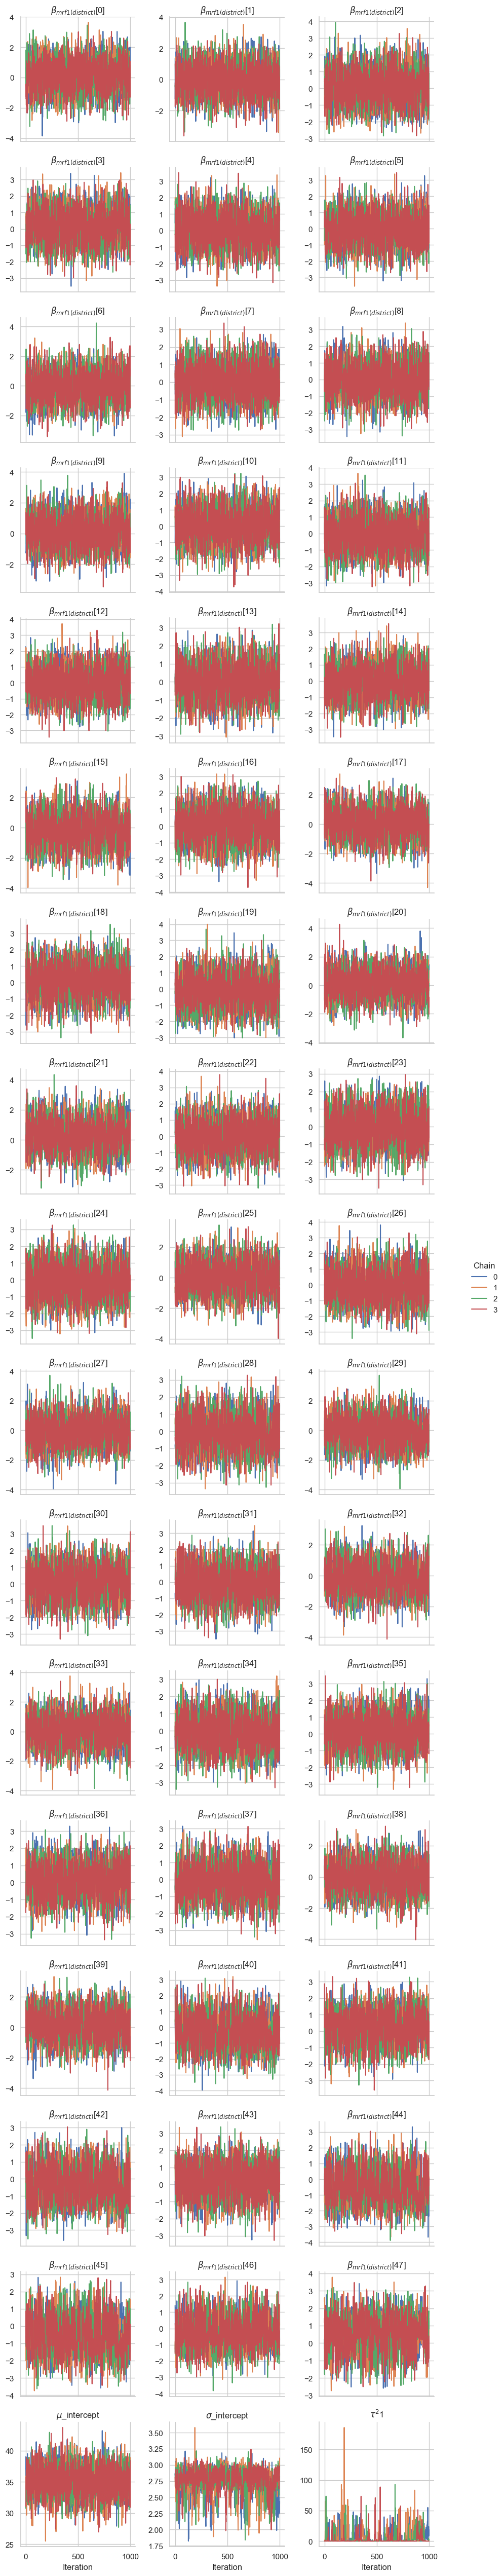

In [17]:
gs.plot_trace(results)

## Predictions

In [18]:
samples = results.get_posterior_samples()

### Predict variables at new x values

In [19]:
newdata = {"district": df.district.to_numpy()}
newdata = tb.labels_to_integers(newdata)
newdata

{'district': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])}

In [20]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["$\\mu$"],
    newdata=newdata,
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["district"] = np.tile(df.district.to_numpy(), len(predictions))
predictions_summary

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,district
0,$\mu$,$\mu$[0],"(0,)",4000,31.953384,65.850113,8.114808,1.006574,647.045276,1185.838378,0.355106,0.338967,15.240422,34.130457,39.865958,19.437119,41.868587,0
1,$\mu$,$\mu$[1],"(1,)",4000,32.657932,49.014961,7.001069,1.007223,681.004732,1417.772955,0.301836,0.356672,18.768474,34.284990,39.813215,21.831100,41.286301,1
2,$\mu$,$\mu$[2],"(2,)",4000,34.132587,28.661186,5.353614,1.006395,1867.912545,1357.895072,0.133801,0.206281,24.511978,34.783293,40.777115,25.868595,41.264061,2
3,$\mu$,$\mu$[3],"(3,)",4000,34.945293,24.052610,4.904346,1.006561,2938.879808,1261.058057,0.093421,0.228014,27.051773,35.114820,41.889342,28.031115,42.631821,3
4,$\mu$,$\mu$[4],"(4,)",4000,37.164173,25.031010,5.003100,1.006155,630.071257,1215.326149,0.220723,0.202962,31.270225,36.215456,47.428953,29.845531,44.092255,4
5,$\mu$,$\mu$[5],"(5,)",4000,34.914162,30.117222,5.487916,1.003398,2964.133103,1307.169802,0.105621,0.227417,26.138794,35.162996,42.401028,27.148380,43.239780,5
6,$\mu$,$\mu$[6],"(6,)",4000,34.157391,39.132759,6.255618,1.008886,1600.227830,977.542645,0.189241,0.319469,22.346049,35.036829,41.408725,25.445850,43.203800,6
7,$\mu$,$\mu$[7],"(7,)",4000,36.833073,24.655851,4.965466,1.004998,1020.090150,1381.667641,0.168143,0.183531,30.870245,36.034649,46.617370,29.513268,44.000095,7
8,$\mu$,$\mu$[8],"(8,)",4000,35.720776,14.241843,3.773837,1.001974,2755.770335,2119.408351,0.072818,0.110824,30.260727,35.559965,41.844835,30.002937,41.508358,8
9,$\mu$,$\mu$[9],"(9,)",4000,34.869831,21.341537,4.619690,1.005000,3353.681565,1382.974568,0.081541,0.187544,27.678481,35.056738,41.246129,28.775347,42.164814,9


In [21]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,district
0,$\mu$,$\mu$[0],"(0,)",4000,31.953384,65.850113,8.114808,1.006574,647.045276,1185.838378,0.355106,0.338967,15.240422,34.130457,39.865958,19.437119,41.868587,0
1,$\mu$,$\mu$[1],"(1,)",4000,32.657932,49.014961,7.001069,1.007223,681.004732,1417.772955,0.301836,0.356672,18.768474,34.284990,39.813215,21.831100,41.286301,1
2,$\mu$,$\mu$[2],"(2,)",4000,34.132587,28.661186,5.353614,1.006395,1867.912545,1357.895072,0.133801,0.206281,24.511978,34.783293,40.777115,25.868595,41.264061,2
3,$\mu$,$\mu$[3],"(3,)",4000,34.945293,24.052610,4.904346,1.006561,2938.879808,1261.058057,0.093421,0.228014,27.051773,35.114820,41.889342,28.031115,42.631821,3
4,$\mu$,$\mu$[4],"(4,)",4000,37.164173,25.031010,5.003100,1.006155,630.071257,1215.326149,0.220723,0.202962,31.270225,36.215456,47.428953,29.845531,44.092255,4


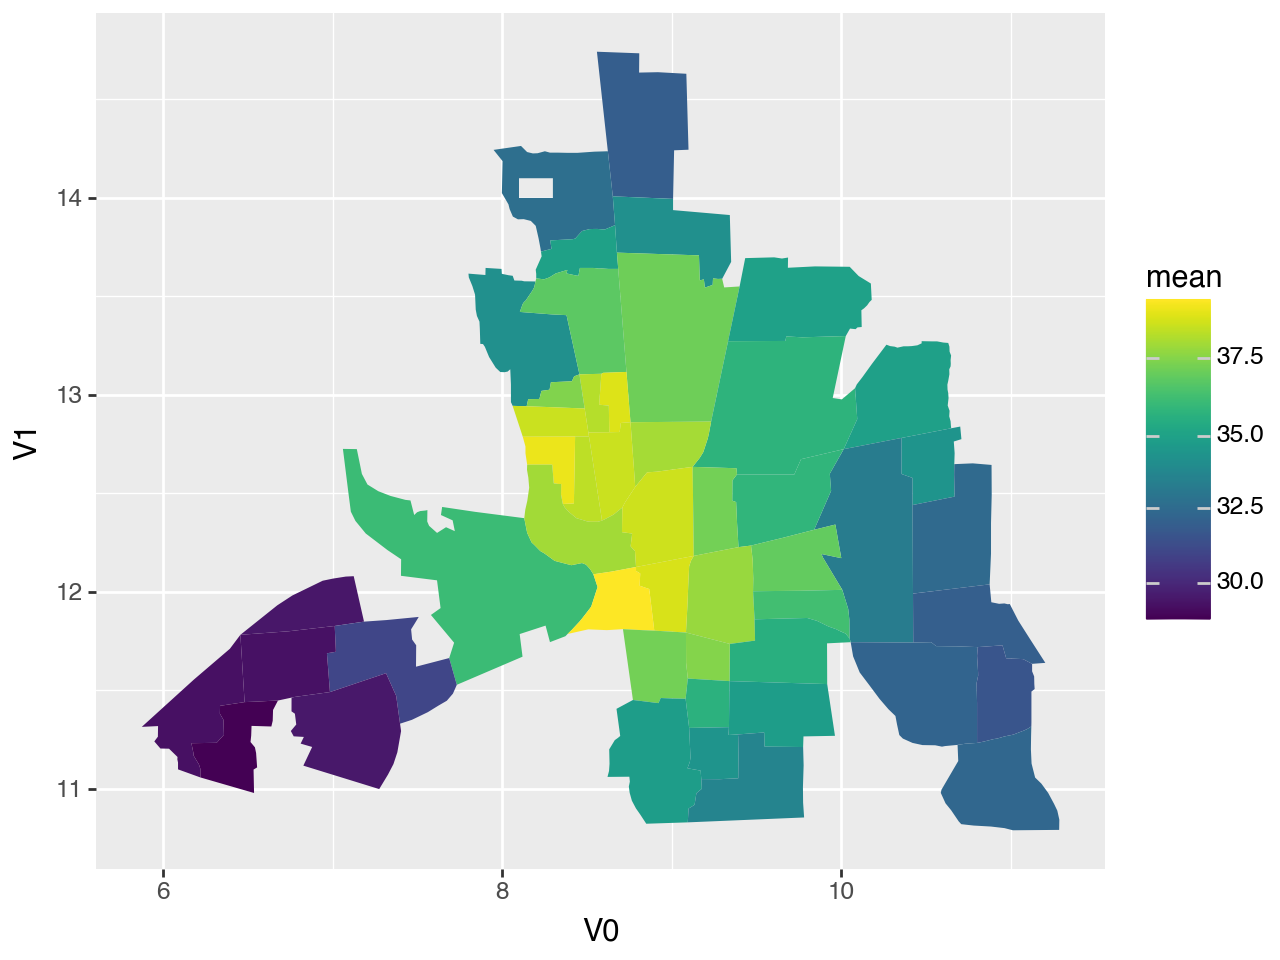

In [22]:
plot_polys(predictions_summary, "mean", polys, "district")

In [23]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["mrf1(district)"],
    newdata=newdata,
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["district"] = np.tile(df.district.to_numpy(), len(predictions))
predictions_summary

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,district
0,mrf1(district),mrf1(district)[0],"(0,)",4000,-3.146152,60.659801,7.788440,1.009633,707.878491,1268.696194,0.352171,0.357742,-20.058282,-0.191552,3.071577,-16.502542,4.314762,0
1,mrf1(district),mrf1(district)[1],"(1,)",4000,-2.441558,43.196037,6.572369,1.012639,676.556217,1314.848017,0.294786,0.353870,-16.227225,-0.144092,3.020083,-13.384769,4.593466,1
2,mrf1(district),mrf1(district)[2],"(2,)",4000,-0.966947,23.588758,4.856826,1.012500,1740.467301,1469.440676,0.128859,0.235456,-10.662685,-0.046743,4.347202,-8.389547,5.770826,2
3,mrf1(district),mrf1(district)[3],"(3,)",4000,-0.154170,18.429981,4.293015,1.013472,2434.206324,1118.419336,0.088144,0.247430,-7.497058,0.007279,5.768757,-7.250279,5.972728,3
4,mrf1(district),mrf1(district)[4],"(4,)",4000,2.064668,20.092308,4.482444,1.011431,484.816190,1159.287884,0.220363,0.230895,-0.860102,0.182935,11.762393,-1.599399,9.540505,4
5,mrf1(district),mrf1(district)[5],"(5,)",4000,-0.185300,25.242004,5.024142,1.010421,2582.765262,1382.924243,0.103116,0.258177,-8.893660,0.033427,6.748732,-7.659691,7.543077,5
6,mrf1(district),mrf1(district)[6],"(6,)",4000,-0.942080,33.618473,5.798144,1.014260,1516.601525,965.476212,0.185371,0.344978,-12.661425,0.010160,5.278577,-10.355226,6.636863,6
7,mrf1(district),mrf1(district)[7],"(7,)",4000,1.733541,19.295816,4.392700,1.012771,848.165313,1336.518746,0.166901,0.214993,-1.572146,0.172632,10.746776,-2.784122,9.083661,7
8,mrf1(district),mrf1(district)[8],"(8,)",4000,0.621283,9.376816,3.062159,1.010329,1986.187215,1374.552336,0.069647,0.153482,-3.094222,0.075328,6.137052,-2.964955,6.178290,8
9,mrf1(district),mrf1(district)[9],"(9,)",4000,-0.229673,15.997963,3.999745,1.013219,3069.219132,1400.688581,0.072875,0.215219,-6.747166,0.003929,5.067201,-6.221119,5.521201,9


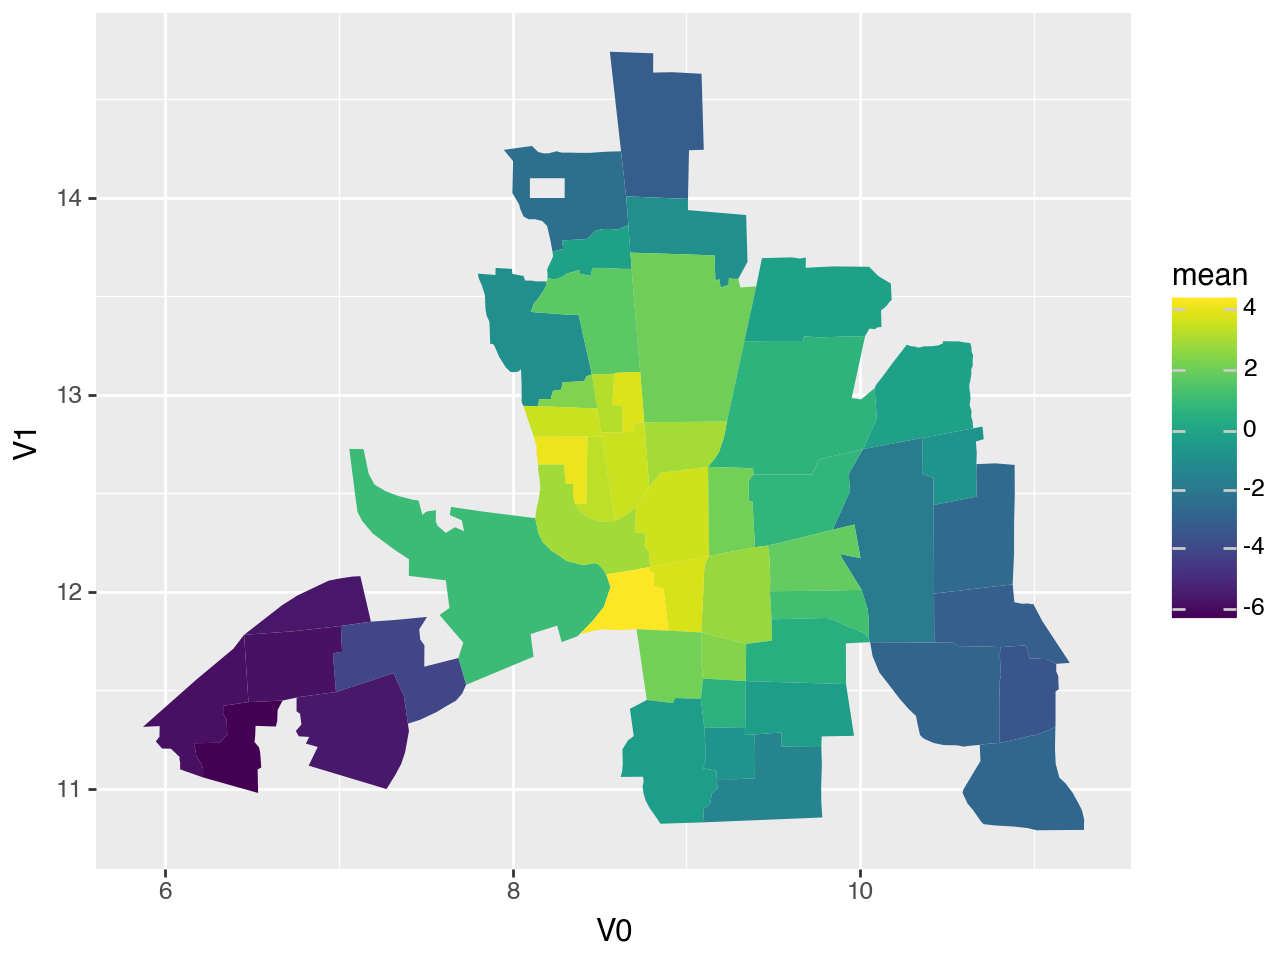

In [24]:
plot_polys(predictions_summary, "mean", polys, "district")

In [25]:
predictions_summary = predictions_summary.reset_index(names="i")

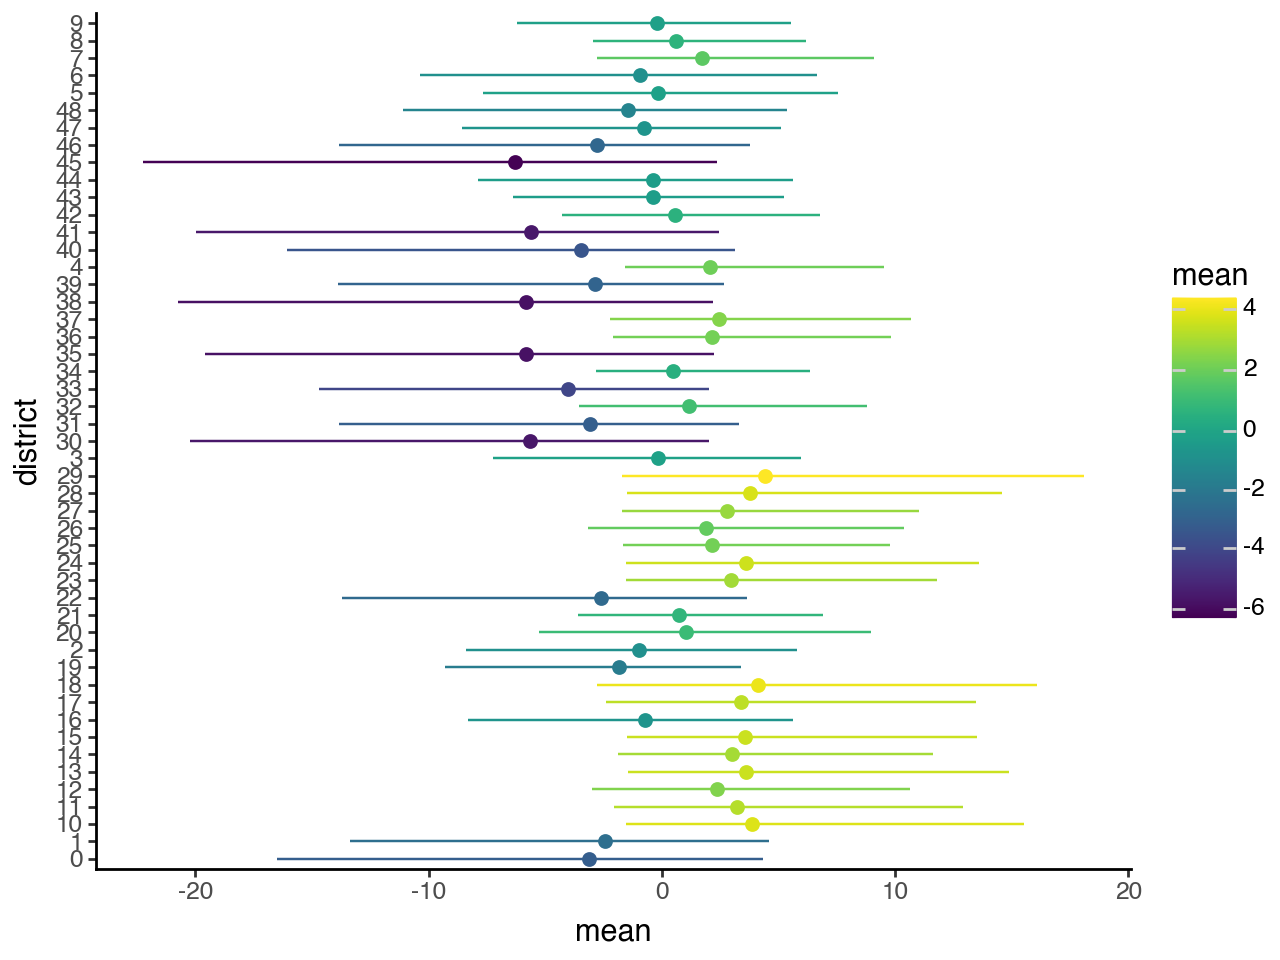

In [26]:
(
    p9.ggplot(predictions_summary)
    + p9.aes("district", "mean", color="mean")
    # + p9.geom_point()
    + p9.geom_pointrange(p9.aes(ymin="hdi_low", ymax="hdi_high"))
    + p9.coord_flip()
    + p9.theme_classic()
    # + p9.geom_pointrange(p9.aes(ymin="q_0.05", ymax="q_0.95"))
)

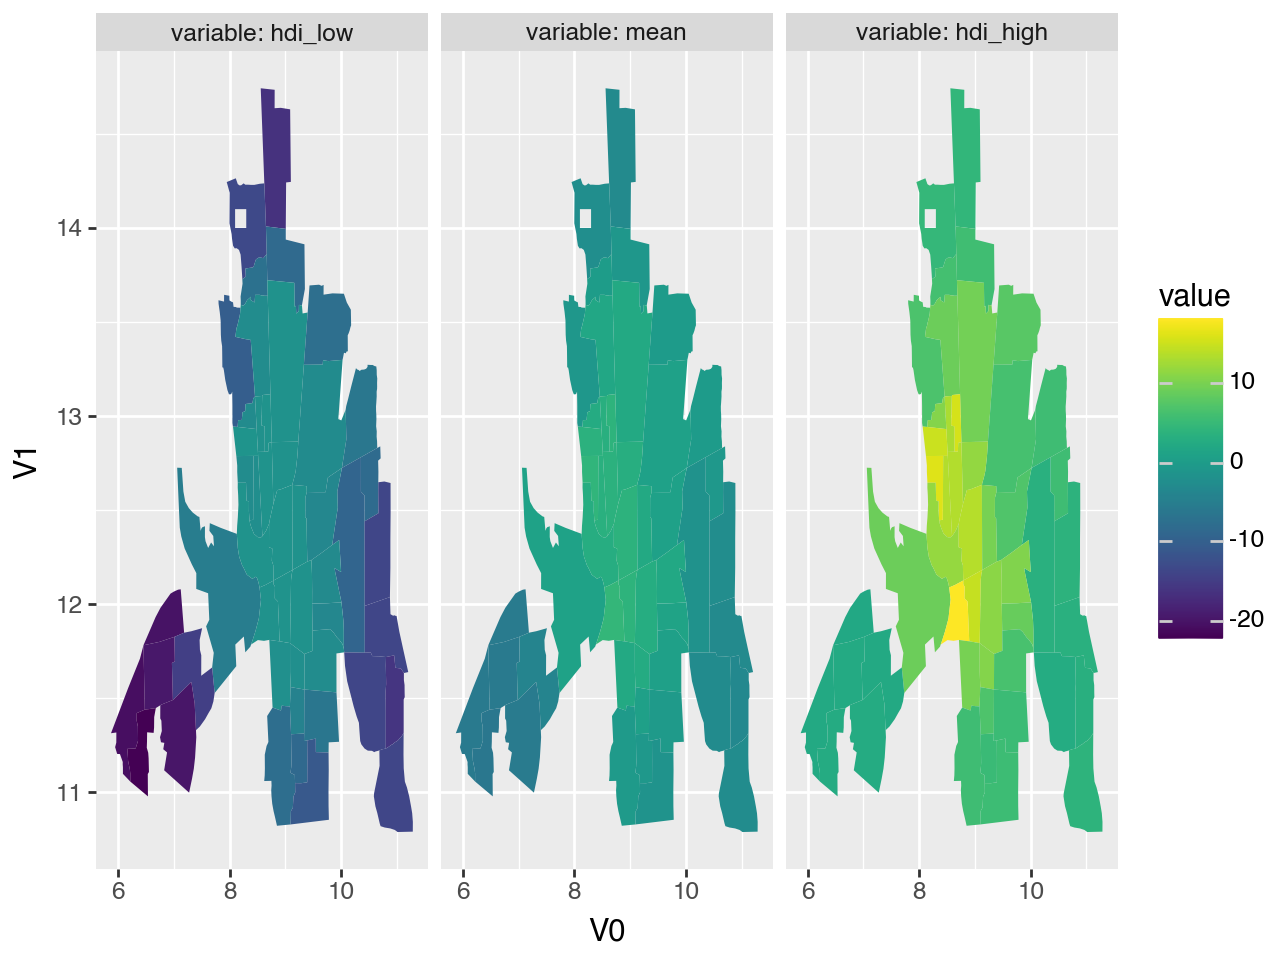

In [27]:
from liesel_gam.plots import plot_regions

plot_regions(
    loc.terms["mrf1(district)"], samples, plot_vars=["hdi_low", "mean", "hdi_high"]
)

ERROR:2025-11-08 17:11:29,435:jax._src.callback:97: jax.pure_callback failed
Traceback (most recent call last):
  File "/Users/johannesbrachem/Documents/git/liesel_gam/.venv/lib/python3.13/site-packages/jax/_src/callback.py", line 95, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ~~~~~~~~^^^^^^^
  File "/Users/johannesbrachem/Documents/git/liesel_gam/.venv/lib/python3.13/site-packages/jax/_src/callback.py", line 73, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/Users/johannesbrachem/Documents/git/liesel_gam/src/liesel_gam/builder/builder.py", line 538, in basis_fun
    r("old_warn <- getOption('warn')")
    ~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/johannesbrachem/Documents/git/liesel_gam/.venv/lib/python3.13/site-packages/ryp.py", line 1300, in r
    raise RuntimeError(error_message)
Runti

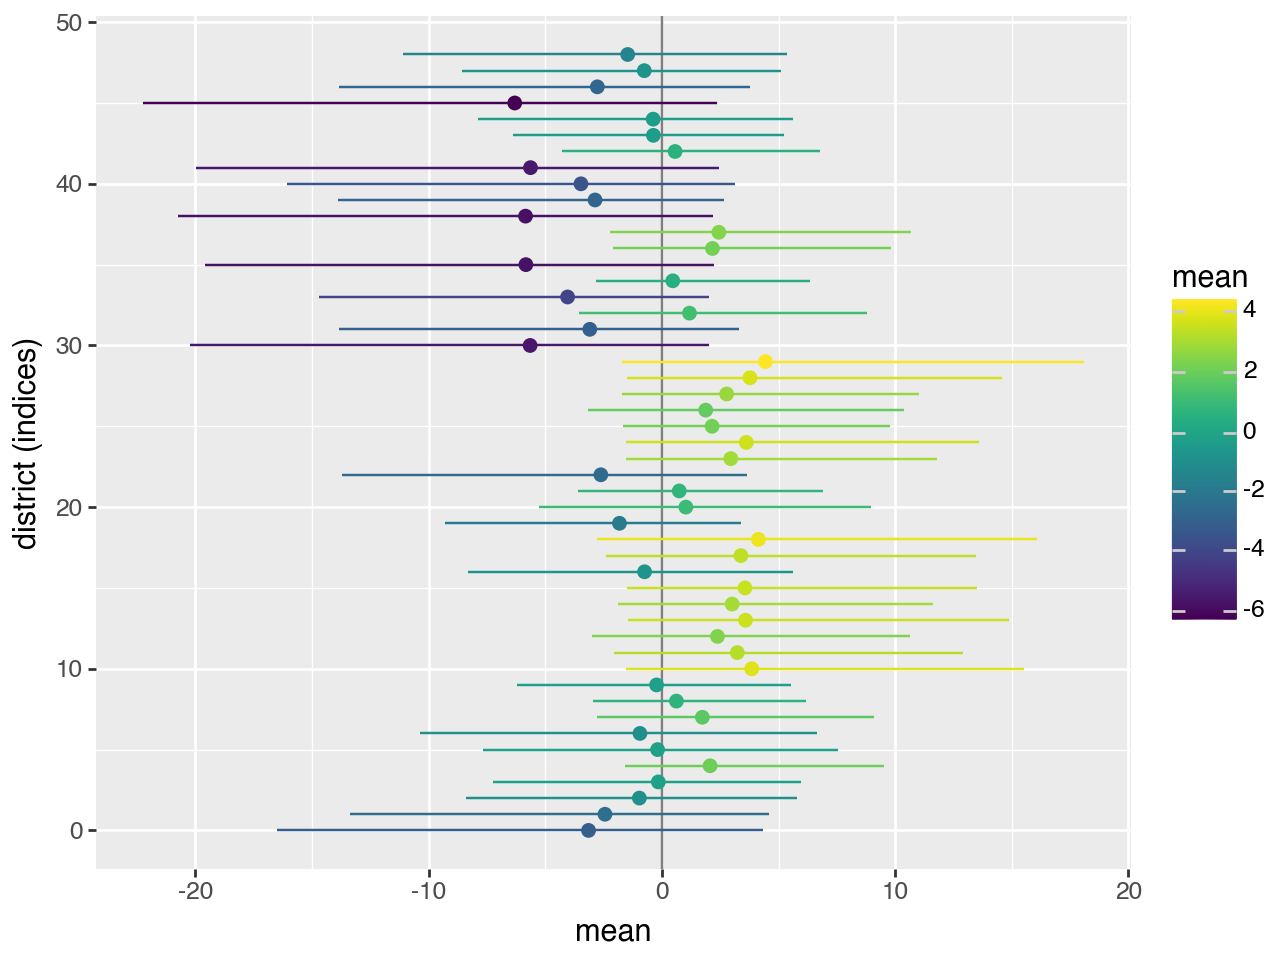

In [28]:
from liesel_gam.plots import plot_forest

plot_forest(loc.terms["mrf1(district)"], samples)